# Evaluating the Ideal Chunk Size for RAG System

## **Setup**



In [ ]:
!pip install llama-index pypdf

In [5]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext,
)
from llama_index.core.evaluation import (
    DatasetGenerator,
    FaithfulnessEvaluator,
    RelevancyEvaluator
)
from llama_index.llms.openai import OpenAI

import openai
import time
openai.api_key = # set your openai api key

## **Data**



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Data**



In [7]:
# Load Data

reader = SimpleDirectoryReader("/content/sample_data/testfiles/")
documents = reader.load_data()

## **Question Generation**



In [10]:

eval_documents = documents
data_generator = DatasetGenerator.from_documents(eval_documents)
eval_questions = data_generator.generate_questions_from_nodes(num = 50)

/usr/local/lib/python3.11/dist-packages/llama_index/core/evaluation/dataset_generation.py:200: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be used instead.)
  return cls(
/usr/local/lib/python3.11/dist-packages/llama_index/core/evaluation/dataset_generation.py:296: DeprecationWarning: Call to deprecated class QueryResponseDataset. (Deprecated in favor of `LabelledRagDataset` which should be used instead.)
  return QueryResponseDataset(queries=queries, responses=responses_dict)


In [11]:
eval_questions

['How many student clubs and organizations are there at Northeastern University?',
 'What opportunities do student clubs and organizations provide for students?',
 'How can student clubs and organizations help students develop their leadership potential?',
 'What types of clubs and organizations are available at Northeastern University?',
 'How does Northeastern University support students in starting their own clubs?',
 'What is emphasized in terms of getting involved in clubs and organizations at Northeastern University?',
 'How can joining academic and professional societies benefit students?',
 'What is the significance of being a part of the Student Government Association at Northeastern University?',
 'How does Northeastern University encourage an entrepreneurial spirit among students?',
 'What resources are available for students who want to learn more about the clubs and organizations at Northeastern University?',
 'What is the purpose of the Student and Family Orientation prog

## Setting Up Evaluators



In [23]:
from llama_index.core import Settings, VectorStoreIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core.node_parser import SentenceSplitter
# Configure the embedding model
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

# Configure the language model
Settings.llm = OpenAI(model="gpt-4o-mini")

# Set chunk size and overlap
Settings.chunk_size = chunk_size
Settings.chunk_overlap = chunk_size // 5  # Example: 20% overlap

## **Response Evaluation For A Chunk Size**

We evaluate each chunk_size based on 3 metrics.

1. Average Response Time.
2. Average Faithfulness.
3. Average Relevancy.

Here's a function,that does just that which has:

1. VectorIndex Creation.
2. Building the Query Engine**.**
3. Metrics Calculation.

In [24]:
import time

def evaluate_response_time_and_accuracy(chunk_size, eval_questions, eval_documents):
    """
    Evaluate the average response time, faithfulness, and relevancy of responses generated by GPT-4o-mini for a given chunk size.

    Parameters:
    chunk_size (int): The size of data chunks being processed.
    eval_questions (list): A list of evaluation questions.
    eval_documents (list): A list of documents to index.

    Returns:
    tuple: A tuple containing the average response time, faithfulness, and relevancy metrics.
    """

    # Configure global settings
    Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
    Settings.llm = OpenAI(model="gpt-4o-mini")
    Settings.chunk_size = chunk_size
    Settings.chunk_overlap = chunk_size // 5  # Example: 20% overlap

    # Create vector index from documents
    vector_index = VectorStoreIndex.from_documents(eval_documents)

    # Build query engine
    query_engine = vector_index.as_query_engine()

    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0
    num_questions = len(eval_questions)

    # Iterate over each question to compute metrics
    for question in eval_questions:
        start_time = time.time()
        response = query_engine.query(question)
        elapsed_time = time.time() - start_time

        # Assuming faithfulness_gpt4 and relevancy_gpt4 are defined evaluators
        faithfulness_result = faithfulness_gpt4.evaluate_response(response=response).passing
        relevancy_result = relevancy_gpt4.evaluate_response(query=question, response=response).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy


## **Testing Across Different Chunk Sizes**

We'll evaluate a range of chunk sizes to identify which offers the most promising metrics

In [26]:
from llama_index.core import Settings

for chunk_size in [128, 256, 512, 1024, 2048]:
    Settings.chunk_size = chunk_size
    avg_response_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size, eval_questions,eval_documents)
    print(f"Chunk size {chunk_size} - Average Response time: {avg_response_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")


Chunk size 128 - Average Response time: 1.77s, Average Faithfulness: 0.92, Average Relevancy: 0.92
Chunk size 256 - Average Response time: 1.86s, Average Faithfulness: 0.90, Average Relevancy: 0.86
Chunk size 512 - Average Response time: 1.80s, Average Faithfulness: 0.90, Average Relevancy: 0.88
Chunk size 1024 - Average Response time: 2.05s, Average Faithfulness: 0.92, Average Relevancy: 0.94
Chunk size 2048 - Average Response time: 1.99s, Average Faithfulness: 0.92, Average Relevancy: 0.94


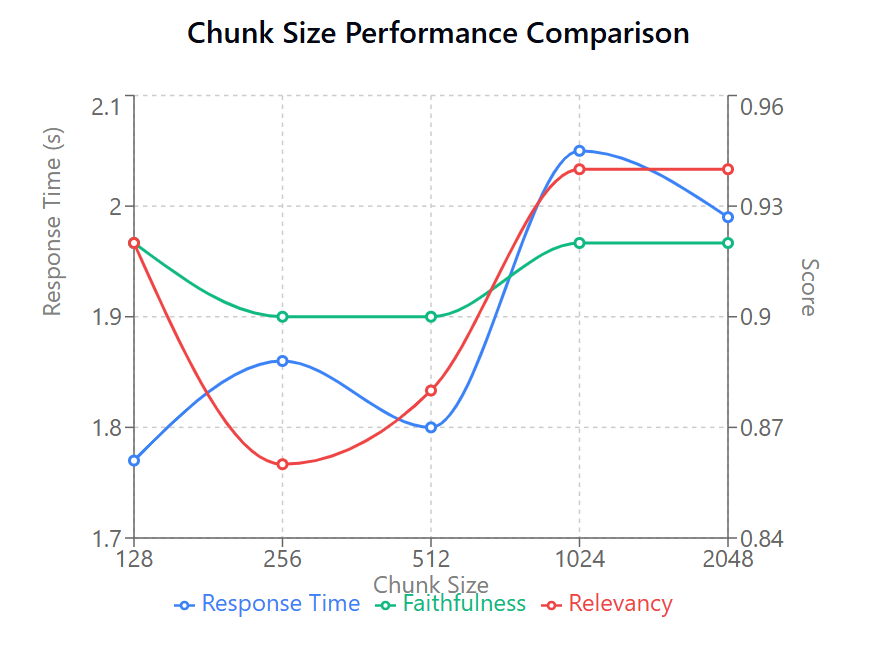